In [1]:
# Notebook for RL Work
# Written By Bryan

# ==== Bandit Imports ====
from Bandits import *    # Custom bandit classes

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
from scipy.optimize import minimize



# ==== Mermaid display imports ====
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

## eGreedy 

#### Trial Configurations

Testbed Means: [0.6927453792020363, 0.057755621523578674, 0.2991586538526794, 0.15437237859863545, 0.7318791915025602, 0.498053623984903, -1.4835585973013772, 0.8113170431427942, -0.2765468876675817, -0.6820635445684884]


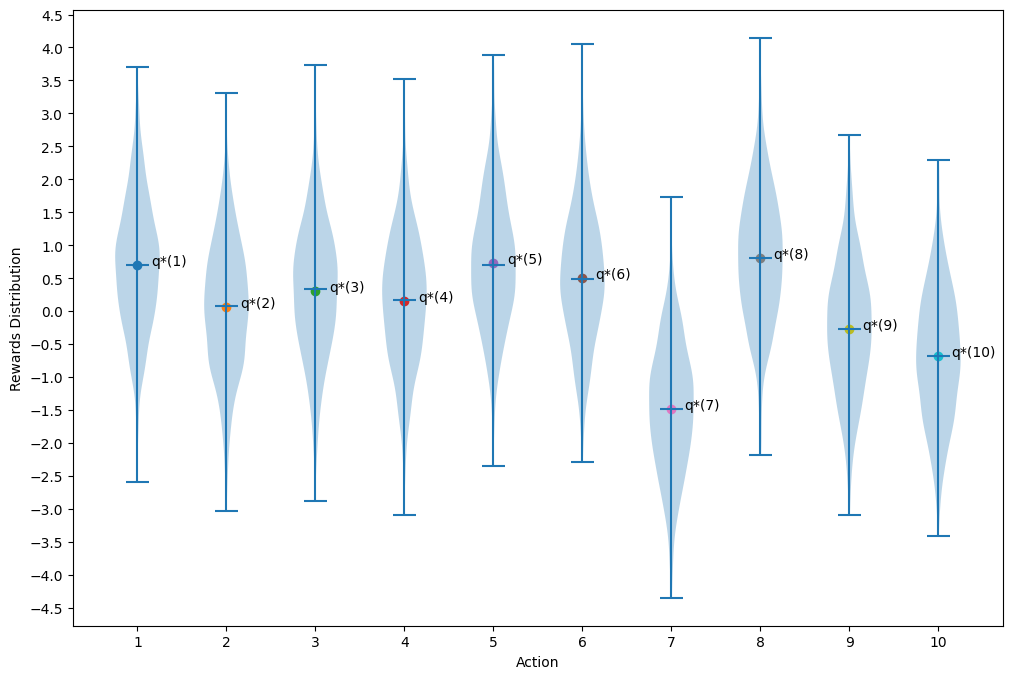

In [2]:
# Create and Show env
env = Testbed(num_sim=1000)

#Trial Params
k = env.k
steps = 300
trial_params = [k, steps]
reward_values = env.q_star

env.show_mean()
env.show_testbed()

100%|██████████| 1000/1000 [00:01<00:00, 526.87it/s]


Showing the following test: 
	Model name: eGreedy
	Action selection: simple_max
	Number of arms: 10
	Epsilon: 0
	Step-size/Learning rate (alpha): 1/n
	Steps: 300
	Initial Q: 0
	Average Reward: 1.017618574635141


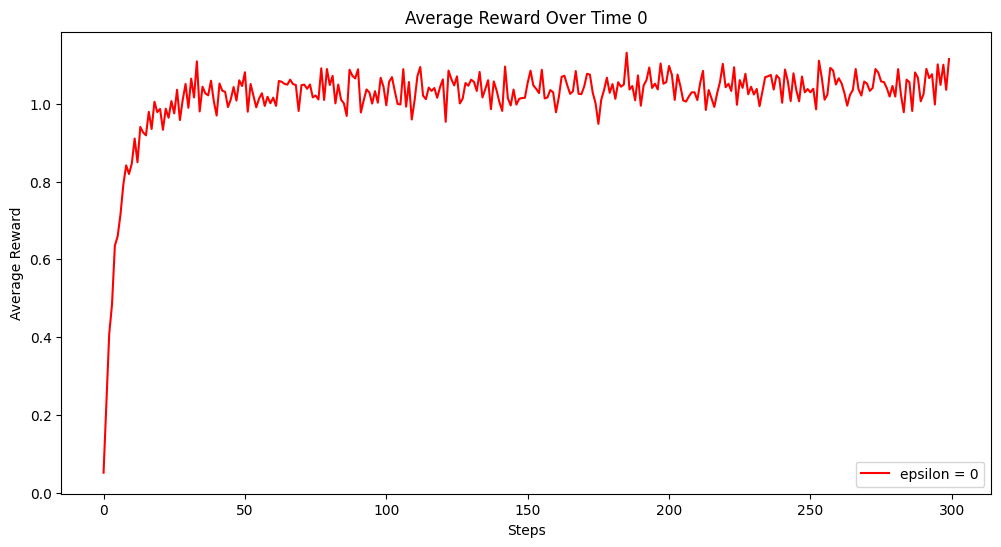

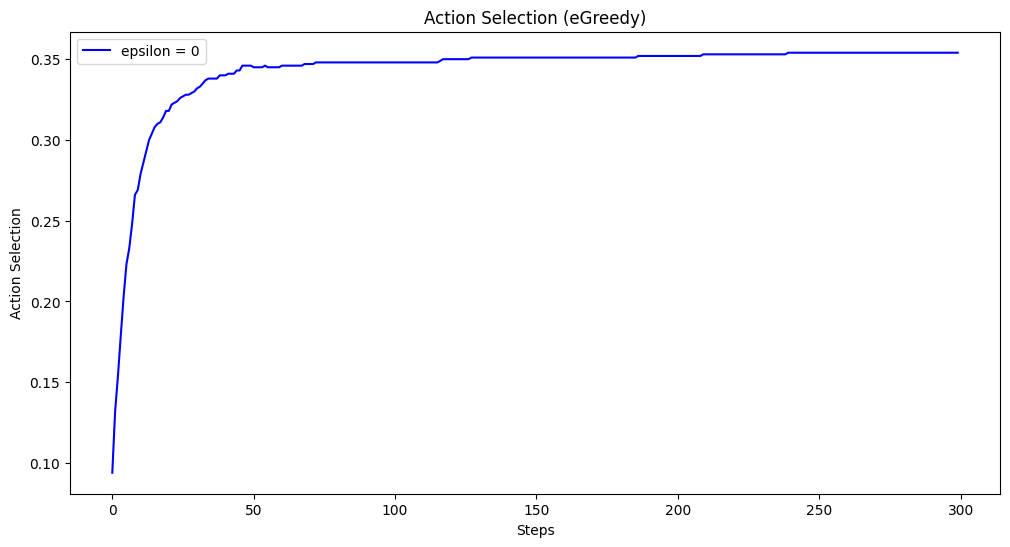

100%|██████████| 1000/1000 [00:01<00:00, 546.55it/s]


Showing the following test: 
	Model name: eGreedy
	Action selection: simple_max
	Number of arms: 10
	Epsilon: 0.1
	Step-size/Learning rate (alpha): 1/n
	Steps: 300
	Initial Q: 0
	Average Reward: 1.2047988175588251


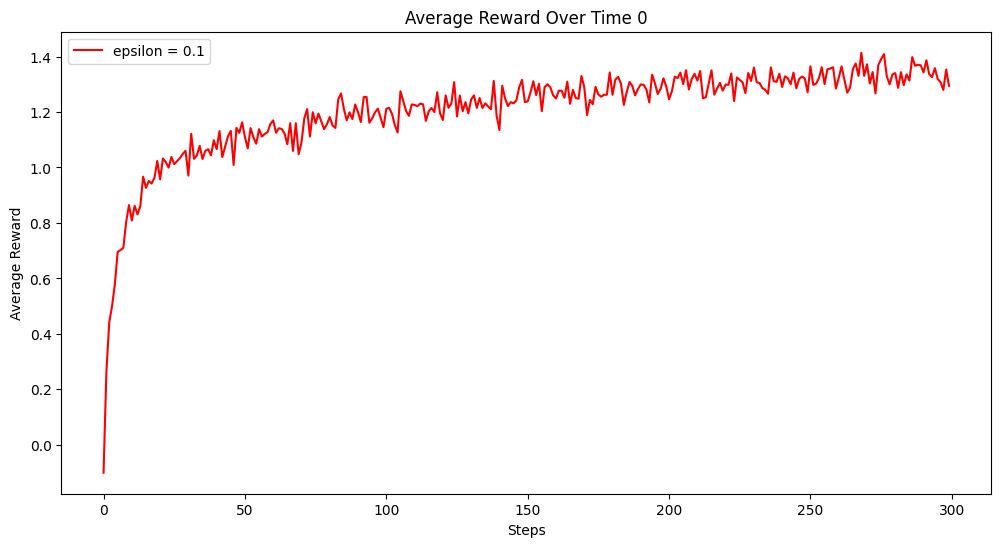

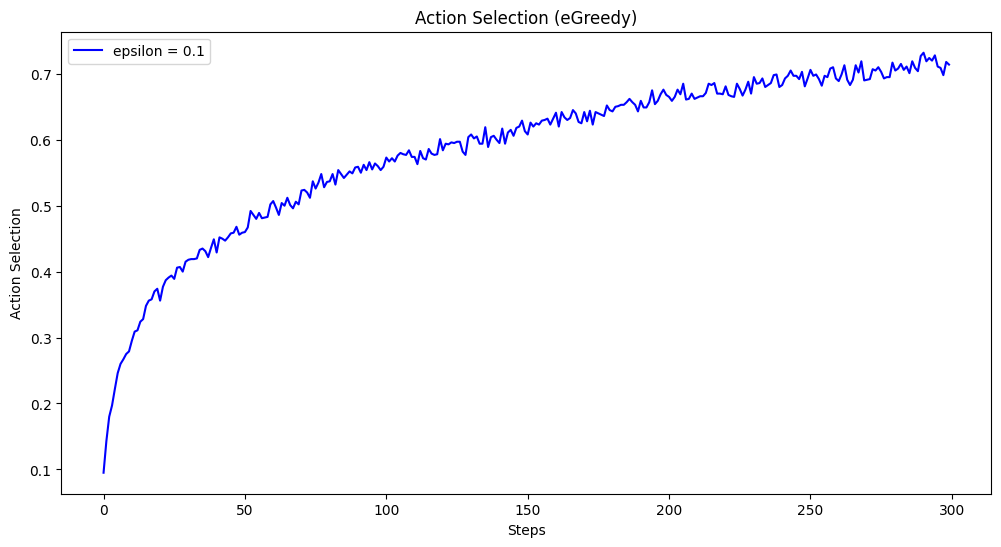

In [3]:
#Model Params
model_type = "EG"
alpha = 0
epsilon = 0
model_params = [alpha, epsilon]
start_val = 0


# Create eGreedy task
eg_0 = create_bandit_task(model_type, model_params, trial_params, reward_values, start_val)
eg_01 = create_bandit_task(model_type="EG", model_params=[0,0.1], trial_params=trial_params, reward_values=reward_values, start_val=start_val)

tasks = [eg_0, eg_01]
for task in tasks:
    task.simulate()
    task.show_results()
    task.show_actions()
    # print("Action Selection: ", task.selection_matrix)
    # print()
    # print("Rewards: ", task.reward_matrix)
    # print("Prediction error: ", task.predictionErr_matrix)
    # print(task.predictionErr_matrix[0][0])


## Softmax

100%|██████████| 1000/1000 [00:02<00:00, 478.57it/s]


Showing the following test: 
	Model name: Softmax
	Action selection: Softmax | temperature = 10
	Number of arms: 10
	Learning rate: 0.6
	Steps: 300
	Initial Q: 1
	Average reward: 1.305070241516916


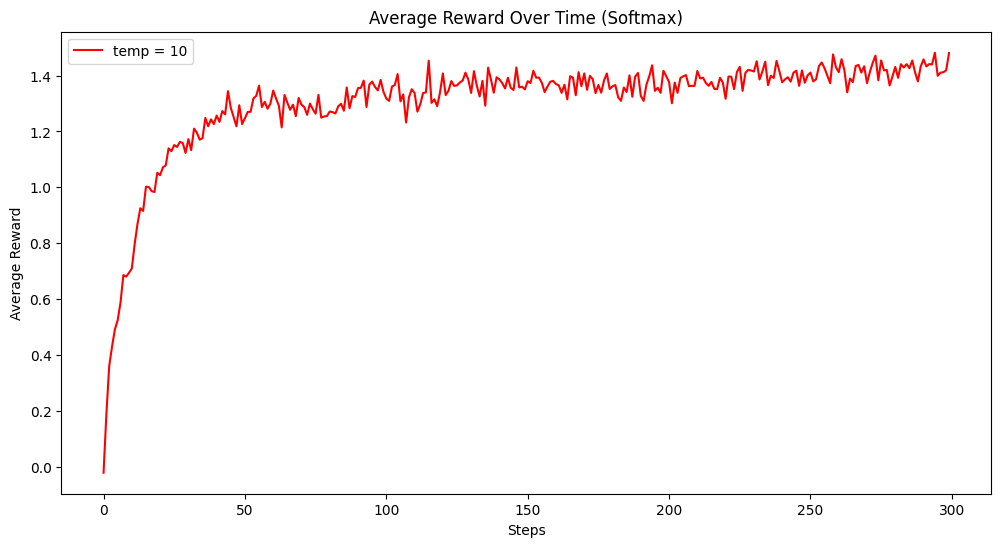

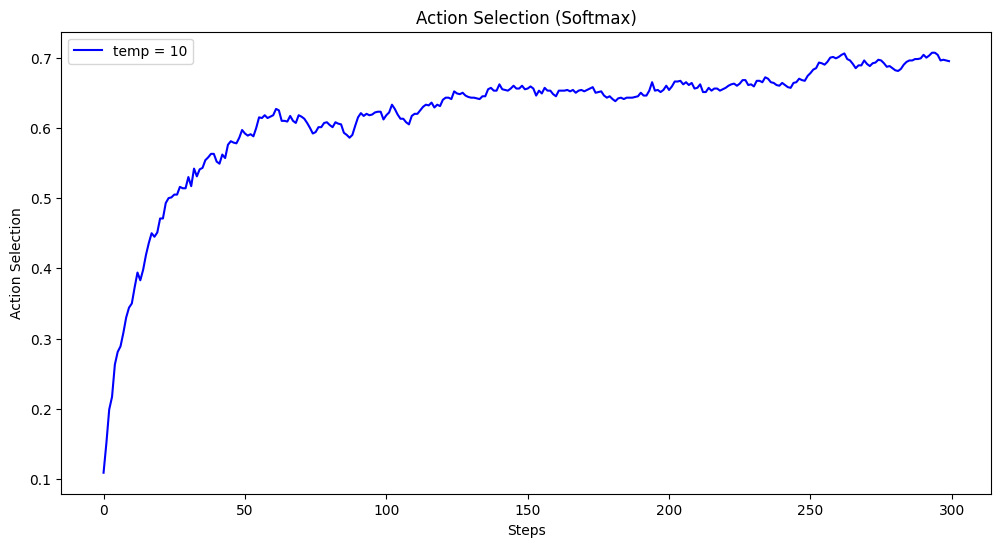

In [4]:
#Model Params
model_type = "SM"
alpha = 0.6
temp = 10                       # inverse temp
model_params = [alpha, temp]
start_val = 1



SM = create_bandit_task(model_type, model_params, trial_params, reward_values, start_val)
SM.simulate()
SM.show_results()
SM.show_actions()

## Softmax_UCB

In [5]:
# Model Params
model_type = "SMUCB"
alpha = 1
temp = 1
uncertParam = 2
#uncert = 2
model_params = [alpha, temp, uncertParam]
start_val = 1

SMUCB = create_bandit_task(model_type=model_type, model_params=model_params, trial_params=trial_params, reward_values=reward_values, start_val=start_val)

SMUCB.simulate()
SMUCB.show_results()

  0%|          | 0/1000 [00:00<?, ?it/s]


0
300


TypeError: 'numpy.int64' object does not support item assignment

## Log-Likelihood

In [ ]:
eg_01.simulate_LL()


## Model Validation

#### Param Recovery
Fit data to model it was simulated with
<ol>
<li>Simulate choices and rewards using chosen parameter values(acts as ground truth)</li>
<li>
Run fitting procedure (neg log likelihood function) on simulated choice AND reward data.
See if we an estimate simulated parameter values (estimates are fitted parameter values)
</li>
</ol>

In [ ]:
# Run this to display mermaid flowchart of parameter recovery
mm("""
flowchart LR
   subgraph input-parameters
   direction TB
   id1([epsilon])
   id2([alpha])
   id3([etc...])
   id1 ~~~ id2 ~~~ id3
   end

   subgraph output-parameters
   direction TB
   id4([epsilon])
   id5([alpha])
   id6([etc...])
   id4 ~~~ id5 ~~~ id6
   end

   simData[(Simulated Data)]
   model((RL Model))
   n([noise])
   fm{{fit data to model}}

   input-parameters --"(1) input"--> model
   model --"(1) creates"--> simData
   simData -."(2) (optional) Add".-> n
   simData --> fm
   n -.-> fm
   fm ~~~ output-parameters
   fm --"(3) Outputs"--> output-parameters
   input-parameters o-- "(4) compare"  --o output-parameters

""")

In [ ]:
num_models = 2      # number of models
num_sims = 30       # number of agents to fit
num_trials = 0      #

reward_modelPR = np.zeros(shape=[num_models, num_sims, num_trials])
choices_modelPR = np.zeros(shape=[num_models, num_sims, num_trials])

# Create Parameters
paraSimPR = paramCreate(num_sims)

# 
paraFitPR = np.zeros(shape=[num_sims, num_Param])
LLArray = np.zeros(shape=[num_sims, num_models])

# number of fitting attempts
num_fit_attempts = 5

for agent in tqdm(range(num_sims)):
    
    # generate environment (non stationary bandit environment from Daw et al in TF Doc)
    environment = Testbed() 

    # eGreedy
    EG = SimpleBandit(arms=10, epsilon=paraSimPR[agent, 0:2], steps=1000, q_star=environment.q_star, initial_Q=0.1)
    EG.simulate()

    # Softmax
    SM = SimpleBandit(arms=10, epsilon=paraSimPR[agent, 2:4], steps=1000, q_star=environment.q_star, initial_Q=0, argmax_func=softmax)
    SM.simulate()
    # Softmax UCB (Softmax Distrubutrion with upper confidence bound action selection)
    #SMUCB_Choice = SimpleBandit(arms=10, epsilon=paraSimPR[param_count, 4:7], steps=1000, q_star=reward_values.q_star, initial_Q=0, argmax_func=UCB)



#### Model Recovery

Fit data to all models
<ol>
<li>
Use simulated choice and reward data from paramater recovery step
</li>

<li>
Calculate negative log likelihood values using each model on the simulated data
</li>
</ol>
